<a href="https://colab.research.google.com/github/applejxd/colaboratory/blob/master/ml/autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## ライブラリの準備

In [1]:
import sklearn
import tensorflow as tf
from tensorflow import keras
import numpy as np

print(f'sklearn    {sklearn.__version__}')
print(f'tensorflow {tf.__version__}')
print(f'keras      {tf.keras.__version__}')
print(f'numpy      {np.__version__}')

sklearn    1.0.2
tensorflow 2.8.2
keras      2.8.0
numpy      1.21.6


In [2]:
# To make the output stable across runs
tf.random.set_seed(42)
np.random.seed(42)

In [3]:
# Check use of GPU
if tf.test.gpu_device_name(): 
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
   print("Please install GPU version of TF, if GPU is available.")

Default GPU Device: /device:GPU:0


## データの準備

In [4]:
%%capture
!pip install kaggle

[Kaggle のマイページから取得した API Token をアップロードして
Kaggle API の有効化](https://qiita.com/fastso/items/43e85fd51d6426d14dd7)

API を使用して[Credit Card Fraud Detection](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud?resource=download)のデータセットをダウンロード

In [5]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 64 bytes


In [7]:
import shutil
import pandas as pd

# データをダウンロード
!kaggle datasets download -d mlg-ulb/creditcardfraud
# 解凍
shutil.unpack_archive("creditcardfraud.zip", ".")
data = pd.read_csv("./creditcard.csv")

data

creditcardfraud.zip: Skipping, found more recently modified local copy (use --force to force download)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


## 前処理

学習データとテストデータを 67:33 で分割.

学習・テストデータで目的変数の比率を同じにする.

In [8]:
from sklearn import model_selection
dataX = data.copy().drop(['Class','Time'],axis=1)
dataY = data['Class'].copy()

X_train, X_test, y_train, y_test = model_selection.train_test_split(
    dataX, dataY, test_size=0.33, random_state=2018, stratify=dataY)

数値変数の正規化

In [10]:
from sklearn import preprocessing

featuresToScale = dataX.columns
sX = preprocessing.StandardScaler(copy=True, with_mean=True, with_std=True)
X_train.loc[:,featuresToScale] = sX.fit_transform(X_train.loc[:,featuresToScale])
X_test.loc[:,featuresToScale] = sX.transform(X_test.loc[:,featuresToScale])

X_train_AE, X_test_AE = X_train.copy(), X_test.copy()

In [11]:
def anomalyScores(originalDF, reducedDF):
    loss = np.sum((np.array(originalDF) - 
                   np.array(reducedDF))**2, axis=1)
    loss = pd.Series(data=loss,index=originalDF.index)
    loss = (loss-np.min(loss))/(np.max(loss)-np.min(loss))
    return loss

In [15]:
from sklearn import metrics
import matplotlib.pyplot as plt

def plotResults(trueLabels, anomalyScores, returnPreds = False):
    preds = pd.concat([trueLabels, anomalyScores], axis=1)
    preds.columns = ['trueLabel', 'anomalyScore']
    precision, recall, thresholds = metrics.precision_recall_curve(
        preds['trueLabel'], preds['anomalyScore'])
    average_precision = metrics.average_precision_score(
        preds['trueLabel'], preds['anomalyScore'])
    
    plt.step(recall, precision, color='k', alpha=0.7, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.3, color='k')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    
    plt.title('Precision-Recall curve: Average Precision = \
        {0:0.2f}'.format(average_precision))

    fpr, tpr, thresholds = metrics.roc_curve(
        preds['trueLabel'], preds['anomalyScore'])
    areaUnderROC = metrics.auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='r', lw=2, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic: Area under the \
        curve = {0:0.2f}'.format(areaUnderROC))
    plt.legend(loc="lower right")
    plt.show()
    
    if returnPreds==True:
        return preds, average_precision

## 2層未完備オートエンコーダの構成

Epoch 1/10
5964/5964 [==============================] - 27s 4ms/step - loss: 0.1209 - accuracy: 0.8090 - val_loss: 0.0365 - val_accuracy: 0.8872
Epoch 2/10
5964/5964 [==============================] - 24s 4ms/step - loss: 0.0373 - accuracy: 0.9014 - val_loss: 0.0373 - val_accuracy: 0.9247
Epoch 3/10
5964/5964 [==============================] - 23s 4ms/step - loss: 0.0394 - accuracy: 0.9341 - val_loss: 0.0374 - val_accuracy: 0.9512
Epoch 4/10
5964/5964 [==============================] - 24s 4ms/step - loss: 0.0386 - accuracy: 0.9543 - val_loss: 0.0377 - val_accuracy: 0.9516
Epoch 5/10
5964/5964 [==============================] - 22s 4ms/step - loss: 0.0388 - accuracy: 0.9544 - val_loss: 0.0363 - val_accuracy: 0.9615
Epoch 6/10
5964/5964 [==============================] - 24s 4ms/step - loss: 0.0390 - accuracy: 0.9558 - val_loss: 0.0376 - val_accuracy: 0.9510
Epoch 7/10
5964/5964 [==============================] - 24s 4ms/step - loss: 0.0391 - accuracy: 0.9593 - val_loss: 0.0382 - val_ac

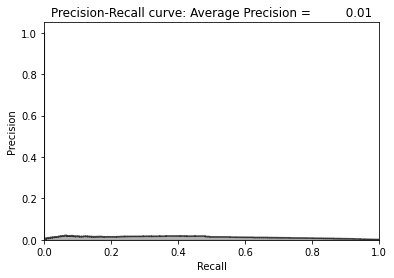

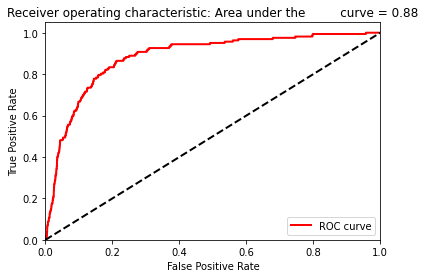

Epoch 1/10
5964/5964 [==============================] - 25s 4ms/step - loss: 0.1187 - accuracy: 0.8230 - val_loss: 0.0373 - val_accuracy: 0.9131
Epoch 2/10
5964/5964 [==============================] - 24s 4ms/step - loss: 0.0394 - accuracy: 0.9130 - val_loss: 0.0358 - val_accuracy: 0.9328
Epoch 3/10
5964/5964 [==============================] - 24s 4ms/step - loss: 0.0378 - accuracy: 0.9267 - val_loss: 0.0358 - val_accuracy: 0.9536
Epoch 4/10
5964/5964 [==============================] - 22s 4ms/step - loss: 0.0378 - accuracy: 0.9502 - val_loss: 0.0368 - val_accuracy: 0.9379
Epoch 5/10
5964/5964 [==============================] - 24s 4ms/step - loss: 0.0368 - accuracy: 0.9475 - val_loss: 0.0356 - val_accuracy: 0.9412
Epoch 6/10
5964/5964 [==============================] - 22s 4ms/step - loss: 0.0395 - accuracy: 0.9464 - val_loss: 0.0362 - val_accuracy: 0.9445
Epoch 7/10
5964/5964 [==============================] - 24s 4ms/step - loss: 0.0394 - accuracy: 0.9516 - val_loss: 0.0375 - val_ac

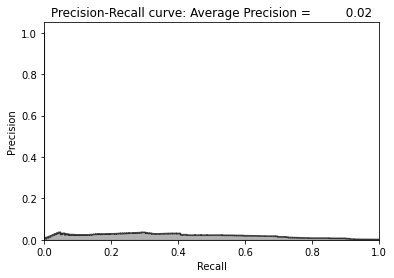

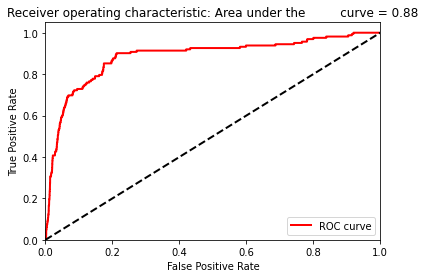

Epoch 1/10
5964/5964 [==============================] - 22s 4ms/step - loss: 0.1289 - accuracy: 0.8199 - val_loss: 0.0374 - val_accuracy: 0.9221
Epoch 2/10
5964/5964 [==============================] - 22s 4ms/step - loss: 0.0396 - accuracy: 0.9427 - val_loss: 0.0365 - val_accuracy: 0.9505
Epoch 3/10
5964/5964 [==============================] - 22s 4ms/step - loss: 0.0387 - accuracy: 0.9505 - val_loss: 0.0371 - val_accuracy: 0.9579
Epoch 4/10
5964/5964 [==============================] - 24s 4ms/step - loss: 0.0383 - accuracy: 0.9596 - val_loss: 0.0380 - val_accuracy: 0.9532
Epoch 5/10
5964/5964 [==============================] - 22s 4ms/step - loss: 0.0388 - accuracy: 0.9541 - val_loss: 0.0364 - val_accuracy: 0.9642
Epoch 6/10
5964/5964 [==============================] - 24s 4ms/step - loss: 0.0390 - accuracy: 0.9573 - val_loss: 0.0372 - val_accuracy: 0.9576
Epoch 7/10
5964/5964 [==============================] - 22s 4ms/step - loss: 0.0392 - accuracy: 0.9597 - val_loss: 0.0367 - val_ac

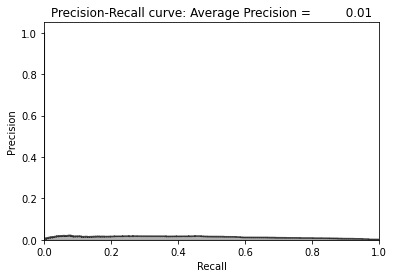

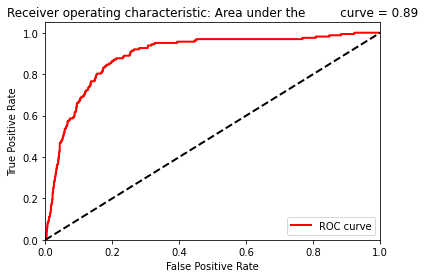

Epoch 1/10
5964/5964 [==============================] - 25s 4ms/step - loss: 0.1185 - accuracy: 0.8194 - val_loss: 0.0380 - val_accuracy: 0.9415
Epoch 2/10
5964/5964 [==============================] - 24s 4ms/step - loss: 0.0397 - accuracy: 0.9579 - val_loss: 0.0369 - val_accuracy: 0.9636
Epoch 3/10
5964/5964 [==============================] - 22s 4ms/step - loss: 0.0393 - accuracy: 0.9610 - val_loss: 0.0378 - val_accuracy: 0.9659
Epoch 4/10
5964/5964 [==============================] - 24s 4ms/step - loss: 0.0385 - accuracy: 0.9648 - val_loss: 0.0384 - val_accuracy: 0.9575
Epoch 5/10
5964/5964 [==============================] - 24s 4ms/step - loss: 0.0387 - accuracy: 0.9599 - val_loss: 0.0365 - val_accuracy: 0.9669
Epoch 6/10
5964/5964 [==============================] - 24s 4ms/step - loss: 0.0390 - accuracy: 0.9567 - val_loss: 0.0382 - val_accuracy: 0.9500
Epoch 7/10
5964/5964 [==============================] - 22s 4ms/step - loss: 0.0392 - accuracy: 0.9600 - val_loss: 0.0369 - val_ac

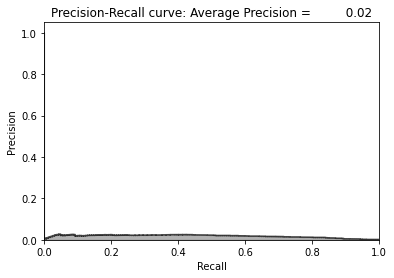

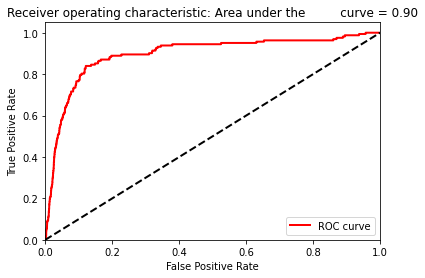

Epoch 1/10
5964/5964 [==============================] - 23s 4ms/step - loss: 0.1244 - accuracy: 0.8212 - val_loss: 0.0375 - val_accuracy: 0.9155
Epoch 2/10
5964/5964 [==============================] - 24s 4ms/step - loss: 0.0400 - accuracy: 0.9380 - val_loss: 0.0369 - val_accuracy: 0.9474
Epoch 3/10
5964/5964 [==============================] - 24s 4ms/step - loss: 0.0391 - accuracy: 0.9513 - val_loss: 0.0375 - val_accuracy: 0.9534
Epoch 4/10
5964/5964 [==============================] - 24s 4ms/step - loss: 0.0386 - accuracy: 0.9609 - val_loss: 0.0381 - val_accuracy: 0.9586
Epoch 5/10
5964/5964 [==============================] - 25s 4ms/step - loss: 0.0387 - accuracy: 0.9593 - val_loss: 0.0365 - val_accuracy: 0.9662
Epoch 6/10
5964/5964 [==============================] - 22s 4ms/step - loss: 0.0392 - accuracy: 0.9561 - val_loss: 0.0373 - val_accuracy: 0.9535
Epoch 7/10
5964/5964 [==============================] - 22s 4ms/step - loss: 0.0392 - accuracy: 0.9594 - val_loss: 0.0371 - val_ac

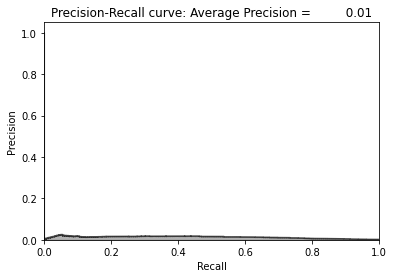

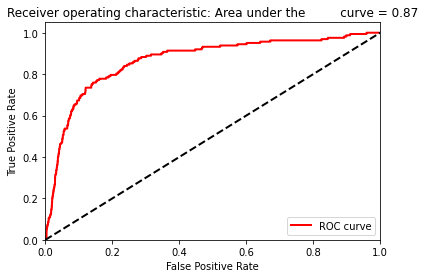

Epoch 1/10
5964/5964 [==============================] - 25s 4ms/step - loss: 0.1205 - accuracy: 0.8055 - val_loss: 0.0381 - val_accuracy: 0.8996
Epoch 2/10
5964/5964 [==============================] - 25s 4ms/step - loss: 0.0395 - accuracy: 0.8993 - val_loss: 0.0362 - val_accuracy: 0.9169
Epoch 3/10
5964/5964 [==============================] - 25s 4ms/step - loss: 0.0388 - accuracy: 0.9242 - val_loss: 0.0363 - val_accuracy: 0.9368
Epoch 4/10
5964/5964 [==============================] - 24s 4ms/step - loss: 0.0388 - accuracy: 0.9408 - val_loss: 0.0373 - val_accuracy: 0.9443
Epoch 5/10
5964/5964 [==============================] - 22s 4ms/step - loss: 0.0383 - accuracy: 0.9490 - val_loss: 0.0361 - val_accuracy: 0.9582
Epoch 6/10
5964/5964 [==============================] - 22s 4ms/step - loss: 0.0391 - accuracy: 0.9550 - val_loss: 0.0372 - val_accuracy: 0.9520
Epoch 7/10
5964/5964 [==============================] - 24s 4ms/step - loss: 0.0393 - accuracy: 0.9595 - val_loss: 0.0372 - val_ac

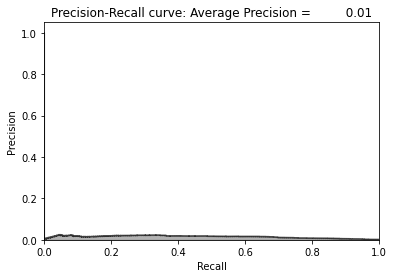

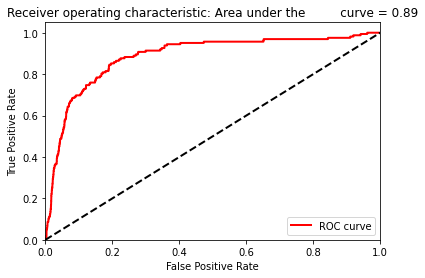

Epoch 1/10
5964/5964 [==============================] - 25s 4ms/step - loss: 0.1231 - accuracy: 0.8089 - val_loss: 0.0382 - val_accuracy: 0.8808
Epoch 2/10
5964/5964 [==============================] - 24s 4ms/step - loss: 0.0393 - accuracy: 0.8920 - val_loss: 0.0361 - val_accuracy: 0.9015
Epoch 3/10
5964/5964 [==============================] - 24s 4ms/step - loss: 0.0382 - accuracy: 0.9033 - val_loss: 0.0360 - val_accuracy: 0.9038
Epoch 4/10
5964/5964 [==============================] - 22s 4ms/step - loss: 0.0384 - accuracy: 0.9149 - val_loss: 0.0370 - val_accuracy: 0.9152
Epoch 5/10
5964/5964 [==============================] - 22s 4ms/step - loss: 0.0382 - accuracy: 0.9244 - val_loss: 0.0362 - val_accuracy: 0.9280
Epoch 6/10
5964/5964 [==============================] - 24s 4ms/step - loss: 0.0393 - accuracy: 0.9269 - val_loss: 0.0375 - val_accuracy: 0.9215
Epoch 7/10
5964/5964 [==============================] - 25s 4ms/step - loss: 0.0392 - accuracy: 0.9382 - val_loss: 0.0371 - val_ac

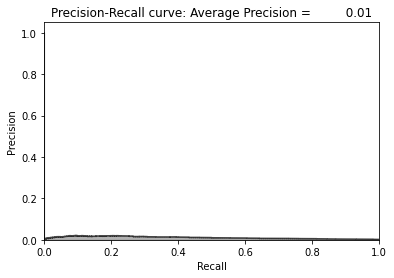

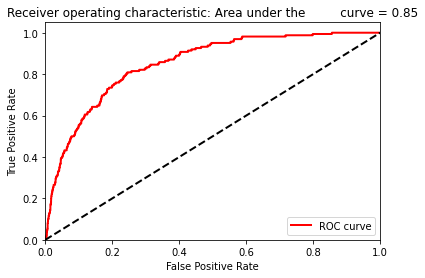

Epoch 1/10
5964/5964 [==============================] - 23s 4ms/step - loss: 0.1426 - accuracy: 0.7969 - val_loss: 0.0375 - val_accuracy: 0.9055
Epoch 2/10
5964/5964 [==============================] - 23s 4ms/step - loss: 0.0388 - accuracy: 0.9200 - val_loss: 0.0356 - val_accuracy: 0.9285
Epoch 3/10
5964/5964 [==============================] - 25s 4ms/step - loss: 0.0372 - accuracy: 0.9344 - val_loss: 0.0358 - val_accuracy: 0.9358
Epoch 4/10
5964/5964 [==============================] - 23s 4ms/step - loss: 0.0366 - accuracy: 0.9414 - val_loss: 0.0358 - val_accuracy: 0.9448
Epoch 5/10
5964/5964 [==============================] - 22s 4ms/step - loss: 0.0367 - accuracy: 0.9465 - val_loss: 0.0355 - val_accuracy: 0.9546
Epoch 6/10
5964/5964 [==============================] - 22s 4ms/step - loss: 0.0365 - accuracy: 0.9543 - val_loss: 0.0355 - val_accuracy: 0.9551
Epoch 7/10
5964/5964 [==============================] - 22s 4ms/step - loss: 0.0367 - accuracy: 0.9541 - val_loss: 0.0384 - val_ac

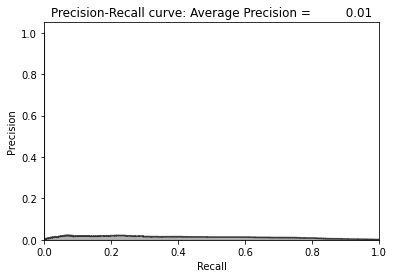

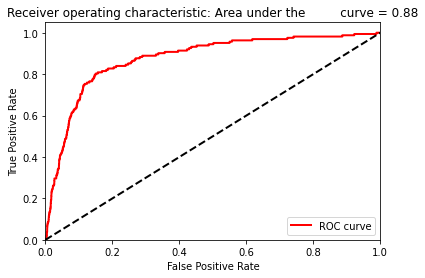

Epoch 1/10
5964/5964 [==============================] - 25s 4ms/step - loss: 0.1135 - accuracy: 0.8220 - val_loss: 0.0369 - val_accuracy: 0.9214
Epoch 2/10
5964/5964 [==============================] - 22s 4ms/step - loss: 0.0400 - accuracy: 0.9444 - val_loss: 0.0366 - val_accuracy: 0.9577
Epoch 3/10
5964/5964 [==============================] - 23s 4ms/step - loss: 0.0390 - accuracy: 0.9560 - val_loss: 0.0380 - val_accuracy: 0.9659
Epoch 4/10
5964/5964 [==============================] - 23s 4ms/step - loss: 0.0383 - accuracy: 0.9653 - val_loss: 0.0379 - val_accuracy: 0.9620
Epoch 5/10
5964/5964 [==============================] - 25s 4ms/step - loss: 0.0387 - accuracy: 0.9655 - val_loss: 0.0365 - val_accuracy: 0.9695
Epoch 6/10
5964/5964 [==============================] - 23s 4ms/step - loss: 0.0393 - accuracy: 0.9597 - val_loss: 0.0370 - val_accuracy: 0.9597
Epoch 7/10
5964/5964 [==============================] - 25s 4ms/step - loss: 0.0390 - accuracy: 0.9635 - val_loss: 0.0379 - val_ac

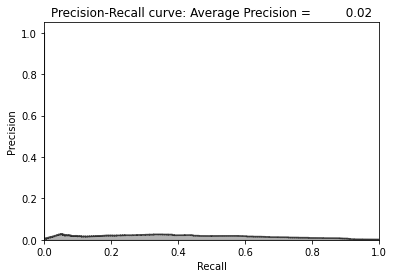

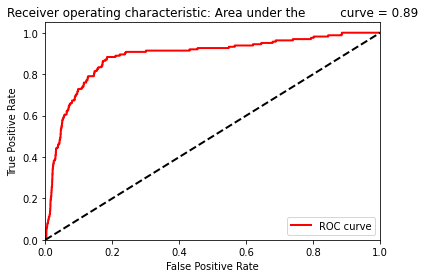

Epoch 1/10
5964/5964 [==============================] - 23s 4ms/step - loss: 0.1235 - accuracy: 0.8191 - val_loss: 0.0374 - val_accuracy: 0.9069
Epoch 2/10
5964/5964 [==============================] - 22s 4ms/step - loss: 0.0388 - accuracy: 0.9064 - val_loss: 0.0358 - val_accuracy: 0.9077
Epoch 3/10
5964/5964 [==============================] - 23s 4ms/step - loss: 0.0373 - accuracy: 0.9152 - val_loss: 0.0352 - val_accuracy: 0.9173
Epoch 4/10
5964/5964 [==============================] - 22s 4ms/step - loss: 0.0367 - accuracy: 0.9295 - val_loss: 0.0355 - val_accuracy: 0.9140
Epoch 5/10
5964/5964 [==============================] - 25s 4ms/step - loss: 0.0361 - accuracy: 0.9259 - val_loss: 0.0343 - val_accuracy: 0.9457
Epoch 6/10
5964/5964 [==============================] - 23s 4ms/step - loss: 0.0360 - accuracy: 0.9443 - val_loss: 0.0354 - val_accuracy: 0.9138
Epoch 7/10
5964/5964 [==============================] - 25s 4ms/step - loss: 0.0361 - accuracy: 0.9423 - val_loss: 0.0373 - val_ac

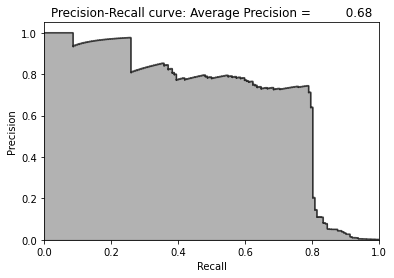

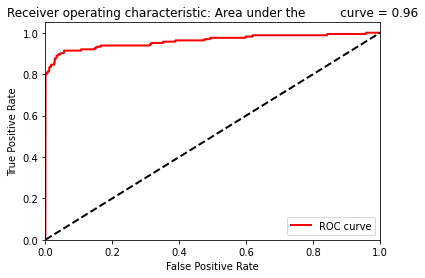

Mean average precision over 10 runs: 0.0817


[0.0129, 0.02, 0.0132, 0.018, 0.0129, 0.0149, 0.0109, 0.013, 0.0164, 0.6844]

In [16]:
# 10 runs - We will capture mean of average precision
test_scores = []
for i in range(0,10):
    # Call neural network API
    model = keras.models.Sequential()

    # Apply linear activation function to input layer
    # Generate hidden layer with 27 nodes
    model.add(keras.layers.Dense(units=27, activation='linear',input_dim=29))

    # Apply linear activation function to hidden layer
    # Generate output layer with 29 nodes
    model.add(keras.layers.Dense(units=29, activation='linear'))

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error', 
                  metrics=['accuracy'])

    # Train the model
    num_epochs = 10
    batch_size = 32

    history = model.fit(x=X_train_AE, y=X_train_AE,
                        epochs=num_epochs,
                        batch_size=batch_size,
                        shuffle=True,
                        validation_data=(X_train_AE, X_train_AE),
                        verbose=1)

    # Evaluate on test set
    predictions = model.predict(X_test, verbose=1)
    anomalyScoresAE = anomalyScores(X_test, predictions)
    preds, avgPrecision = plotResults(y_test, anomalyScoresAE, True)
    test_scores.append(avgPrecision)
    model.reset_states()

print(f"Mean average precision over 10 runs: {round(np.mean(test_scores),4)}")
[round(x,4) for x in test_scores]